In [3]:
# imports
import jax
import jax.numpy as np
import jax.random as jnp_random
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap#EK: , partial
from functools import partial #EK: added in
from jax.scipy.special import logsumexp
from jax.lax import scan
from jax.ops import index, index_add, index_update
from jax.experimental import optimizers
from jax.numpy import concatenate as cat
import timeit

import random
import pickle as pkl
import scipy

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd

from regions.core import PixCoord
from regions import RectanglePixelRegion
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import cv2

In [4]:
# binary image classifier
class Classifier(object):

    def __init__(self):
        self.fpsize = 200
        self.lower, self.tp, self.fp = onp.load('classifier_params.npy')
        print(self.lower, self.tp, self.fp)

    @staticmethod
    def _red_ratio(im):
        return (2 * im[:, :, 0] + 1) / (im[:, :, 1] + im[:, :, 2] + 1)

    def collect_data(self, data_file):
        fpsize = self.fpsize
        cap = cv2.VideoCapture(0)
        ret, frame = cap.read()
        frame = frame[:, :, (2,1,0)].astype(np.float32) / 255
        plt.imshow(frame)
        plt.grid()
        plt.show(block=False)

        x, y = [int(num) for num in input('Enter x and y: ').split()]

        plt.close()

        frame_padded = onp.pad(frame, ((fpsize, fpsize), (fpsize, fpsize), (0, 0)))
        vals = self._red_ratio(frame_padded)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(vals)
        
        max_red = onp.zeros((frame.shape[0] + fpsize, frame.shape[1] + fpsize))
        target_inside = onp.zeros((frame.shape[0] + fpsize, frame.shape[1] + fpsize))
        for r in range(0, frame.shape[0]+fpsize):
            for c in range(0, frame.shape[1]+fpsize):
                max_red[r, c] = onp.max(vals[r:r+fpsize, c:c+fpsize])
                if (r - fpsize) <= y and (r > y) and (c - fpsize) <= x and (c > x):
                    target_inside[r, c] = 1
        
        ax2.imshow(max_red)
        ax3.imshow(target_inside)
        plt.show()

        onp.save(data_file, onp.stack([max_red.flatten(), target_inside.flatten()], axis=1))

    def get_video(self, nframes):
        plt.pause(10)
        cap = cv2.VideoCapture(0)
        video = []
        for i in range(nframes):
            if i % 100 == 0:
                print(i)
            ret, frame = cap.read()
            frame = frame[:, :, (2,1,0)].astype(np.float32) / 255
            video.append(frame)

        cap.release()
        return video

    def get_predictions(self, t, video, bounding_boxes):
        frame = video[t]
        predictions = []
        mask = onp.zeros(frame.shape, dtype=onp.int16)
        for bb in bounding_boxes:
            r0 = max(0, bb[0])
            r1 = min(frame.shape[0], bb[1])
            c0 = max(0, bb[2])
            c1 = min(frame.shape[1], bb[3])
            max_red = np.max(self._red_ratio(frame[r0:r1, c0:c1, :]))
            predictions.append(self.lower < max_red)
        return predictions

    def show(self, t, video, bounding_boxes, ax):
        frame = video[t]
        mask = onp.zeros(frame.shape, dtype=onp.int16)
        for bb in bounding_boxes:
            r0 = max(0, bb[0])
            r1 = min(frame.shape[0], bb[1])
            c0 = max(0, bb[2])
            c1 = min(frame.shape[1], bb[3])
            mask[r0:r1, c0:c1, :] = 1
        ax.imshow(
            (np.max(self._red_ratio(frame[r0:r1, c0:c1, :])) > self.lower).reshape((1,1)), 
            extent=(0, 1, 1, 0), vmin=0, vmax=1, cmap='bwr'
        )

In [ ]:
# collect data for classifier to train on
input('press enter if you actually want to run this')
c = Classifier()
plt.pause(5)
for i in range(20):
    c.collect_data(f'data/{i}.npy')

KeyboardInterrupt: Interrupted by user

In [ ]:
# optimize the classifier using training data
input('press enter if you actually want to run this')
from scipy.optimize import minimize

def negative_mutual_info(f, fhat):
    p_f = np.mean(f)
    p_fhat = np.mean(fhat)
    if p_fhat == 0 or p_fhat == 1:
        return 0

    neg_mi = 0
    f_and_fhat = np.mean(f * fhat)
    if f_and_fhat != 0:
        neg_mi -= f_and_fhat * np.log(f_and_fhat / (p_f * p_fhat))

    f_and_not_fhat = np.mean(f * (1-fhat))
    if f_and_not_fhat != 0:
        neg_mi -= f_and_not_fhat * np.log(f_and_not_fhat / (p_f * (1-p_fhat)))

    not_f_and_fhat = np.mean((1-f) * fhat)
    if not_f_and_fhat != 0:
        neg_mi -= not_f_and_fhat * np.log(not_f_and_fhat / ((1-p_f) * p_fhat))

    not_f_and_not_fhat = np.mean((1-f) * (1-fhat))
    if not_f_and_not_fhat != 0:
        neg_mi -= not_f_and_not_fhat * np.log(not_f_and_not_fhat / ((1-p_f) * (1-p_fhat)))

    print(neg_mi)
    return neg_mi

data_list = []
for i in range(20):
    data_list.append(np.load(f'data/{i}.npy'))

data = np.concatenate(data_list, axis=0)
x = data[:, 0]
f = data[:, 1]

fhat_func = lambda x, lower: ((lower < x)).astype(np.int32)
cost = lambda lower: negative_mutual_info(f, fhat_func(x, lower))

lower_start = np.mean(x[f == 1]) - .1
res = minimize(cost, lower_start, method='Nelder-Mead')
print(res)

lower = res.x
tp = np.sum(fhat_func(x, lower) * f) / np.sum(f)
fp = np.sum(fhat_func(x, lower) * (1-f)) / np.sum(1-f)
tn = np.sum((1-fhat_func(x, lower)) * (1-f)) / np.sum(1-f)
fn = np.sum((1-fhat_func(x, lower)) * f) / np.sum(f)
print('True Positive', tp)
print('False Positive', fp)
print('True Negative', tn)
print('False Negative', fn)

np.save('classifier_params.npy', np.array([res.x[0], tp, fp]))

press enter if you actually want to run this
-0.2225008
-0.20653126
-0.21989292
-0.22112077
-0.22443263
-0.20653126
-0.20653126
-0.2237476
-0.22590187
-0.20653126
-0.20653126
-0.22499092
-0.22687711
-0.20653126
-0.20653126
-0.22656763
-0.22698754
-0.20653126
-0.20653126
-0.22712423
-0.22687711
-0.2272551
-0.22698754
-0.22716871
-0.22685896
-0.2271691
-0.22725573
-0.22685896
-0.22685896
-0.22725551
-0.22685896
-0.22725551
-0.22725551
 final_simplex: (array([[1.32726616],
       [1.32720422]]), array([-0.22725573, -0.22725551]))
           fun: -0.22725573182106018
       message: 'Optimization terminated successfully.'
          nfev: 33
           nit: 16
        status: 0
       success: True
             x: array([1.32726616])
True Positive 0.99472624
False Positive 0.0074251695
True Negative 0.9925748
False Negative 0.00527375


In [36]:
# setting up the environment and initial state
# sensor = Classifier()
# T = sensor.tp
# F = sensor.fp
T = .2
F = .05
image_size = onp.array((480, 640))
rect_dims = onp.array([200/640, 200/480])
# rect_dims = onp.array([.5, .5])
size = 30

def mi(distribution, rect_dims):
    size = distribution.shape[0]
    reg = RectanglePixelRegion(center=PixCoord(15, 15), width=rect_dims[1]*size, height=rect_dims[0]*size)
    mask = reg.to_mask().data
    
    import matplotlib
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
    matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
    matplotlib.rcParams['mathtext.fontset'] = 'cm'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(7, 7/3))
    fig.subplots_adjust(right=.95, wspace=.02)
    cbar_ax = fig.add_axes([.96, 0.25, .02, 0.5])
    
    im1 = ax1.imshow(reg.to_mask().to_image((size, size)), cmap='gray')
    ax1.axis('off')
#     plt.colorbar(pad=0.01, shrink=.9)
    mu = convolve2d(distribution, mask, mode='same').flatten() # EK: could not find correlate2d
    # EK: mu = correlate2d(distribution, mask, mode='same').flatten()
    mu = np.clip(mu, 1e-9, 1 - 1e-9)
    
    ax2.imshow(distribution, cmap='gray')
#     plt.colorbar(pad=0.01, shrink=.9)
    ax2.axis('off')
    
    ax3.imshow(mu.reshape((size, size)), cmap='gray')
#     plt.colorbar(pad=0.01, shrink=.9)
    ax3.axis('off')
    pos = T*mu + F*(1-mu)
    mi = (
        -T*mu*onp.log(pos / T) - 
        (1-T)*mu*onp.log((1-pos) / (1-T)) - 
        F*(1-mu)*onp.log(pos / F) -
        (1-F)*(1-mu)*onp.log((1-pos)/(1-F))
    )
    
    ax4.imshow(mi.reshape((size, size)), cmap='gray')
#     plt.colorbar(pad=0.01, shrink=.9)
    ax4.axis('off')

    
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.set_ticks([0,1])
    cbar.set_ticklabels(['Low', 'High'])
#     fig.tight_layout()
    ax1.set_title('(a) $\mathbf{S}$')
    ax2.set_title('(b) $p_Y$')
    ax3.set_title('(c) $\mu$')
    ax4.set_title('(d) $I_x$')
    fig.savefig('mi_calc.pdf')
    plt.show()
    
    return mi.reshape((size, size))

alpha = .5
def alpha_mi(distribution, rect_dims):
    size = distribution.shape[0]
    reg = RectanglePixelRegion(center=PixCoord(25, 25), width=rect_dims[1]*size, height=rect_dims[0]*size)
    mask = reg.to_mask().data
#     plt.imshow(reg.to_mask().to_image((size, size)), cmap='gray')
#     plt.axis('off')
#     plt.colorbar(pad=0.01, shrink=.9)
#     plt.show()
    mu = convolve2d(distribution, mask, mode='same').flatten() # EK: could not find correlate2d
    # EK: mu = correlate2d(distribution, mask, mode='same').flatten()
    mu = np.clip(mu, 1e-9, 1 - 1e-9)
    
#     plt.imshow(distribution, cmap='gray')
#     plt.colorbar(pad=0.01, shrink=.9)
#     plt.axis('off')
#     plt.show()
    
#     plt.imshow(mu.reshape((size, size)), cmap='gray')
#     plt.colorbar(pad=0.01, shrink=.9)
#     plt.axis('off')
#     plt.show()
#     munz = mu
#     mi = onp.zeros(mu.shape[0])
    pos = T*mu + F*(1-mu)
    mi = (1 / (alpha - 1)) * (
        pos*np.log(
            mu*(T/pos)**alpha + 
            (1-mu)*(F/pos)**alpha
        ) + 
        (1 - pos)*np.log(
            mu*((1-T)/(1-pos))**alpha + 
            (1-mu)*((1-F)/(1-pos))**alpha
        )
    )
    
#     plt.imshow(mi.reshape((size, size)), cmap='gray')
#     plt.colorbar(pad=0.01, shrink=.9)
#     plt.axis('off')
#     plt.show()
    return mi.reshape((size, size))

def f(x, u): # dynamics
    xnew = x + np.tanh(u)
    return xnew, x

def get_hk(k): # normalizing factor for basis function
    _hk = (2. * k + onp.sin(2 * k))/(4. * k)
    # EK: _hk[onp.isnan(_hk)] = 1.
    _hk = _hk.at[onp.isnan(_hk)].set(1.) # EK: this was complaining that jax arrays are immutable
    return onp.sqrt(onp.prod(_hk))

def fk(x, k): # basis function
    return np.prod(np.cos(x*k))


k1, k2 = np.meshgrid(*[np.arange(0, 15, step=1)]*2)
k = np.stack([k1.ravel(), k2.ravel()]).T
k = np.pi*k

lamk = (1.+np.linalg.norm(k/np.pi,axis=1)**2)**(-4./2.)
# lamk = np.exp(-0.8 * np.linalg.norm(k, axis=1))
# lamk = np.ones((len(k), 1))
hk = []
for ki in k:
    hk.append(get_hk(ki))
hk = np.array(hk)

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)
def get_ck(tr, k):
    ck = np.mean(vmap(partial(fk_vmap, tr))(k), axis=1)
    ck = ck / hk
    return ck

# EK: uncommented function
@jit
def fourier_ergodic_loss_no_history(u, x0, phik, k):
    xf, tr = scan(f, x0, u)
    ck = get_ck(tr, k)
    return np.sum(lamk*np.square(phik - ck)) \
            + 1e-3 * np.mean(u**2) + 100 * np.mean((tr - np.array([0.5,0.5]))**8)

def fourier_ergodic_loss(u, x0, phik, k, history):
    xf, tr = scan(f, x0, u)
    tr = cat([tr, history], axis=0)
    ck = get_ck(tr, k)
    return np.sum(lamk*np.square(phik - ck)) \
            + 1e-3 * np.mean(u**2) + 100 * np.mean((2*(tr - np.array([0.5,0.5])))**30)

dl = jit(grad(fourier_ergodic_loss))

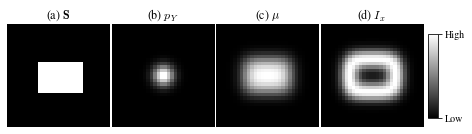

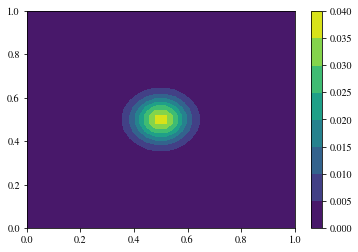

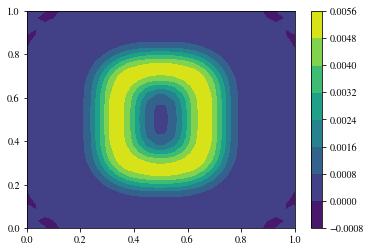

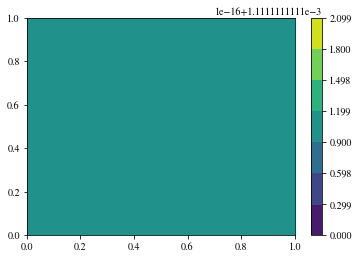

In [10]:
# test plots for different utility distributions
x1g, x2g = onp.meshgrid(
    np.linspace(0, 1, size),
    np.linspace(0, 1, size),
    indexing='ij'
)
x1 = x1g.flatten()
x2 = x2g.flatten()
xvec = onp.stack([x1, x2], axis=1)

p_dist = onp.exp(-(np.square(x1 - .5) + onp.square(x2 - .5)) / .1**2).reshape((size, size))
# p_dist = onp.ones((size, size)) #4 * onp.exp(-(np.square(x1 - .5) + onp.square(x2 - .5)) / .8**2).reshape((size, size))
# p_dist = p_dist / onp.sum(p_dist)
# p_dist = onp.zeros((size, size))
# p_dist.flat[(x1 > .1) & (x2 > .1) & (x1 < .9) & (x2 < .9)] = 1
# p_dist = onp.ones((size, size))
# p_dist.flat[31*15] = 1
p_dist = p_dist / onp.sum(p_dist)

mi_dist = mi(p_dist.reshape((size, size)), rect_dims)
mi_dist = mi_dist / np.sum(mi_dist)

uniform_dist = onp.ones(p_dist.shape)
uniform_dist = uniform_dist / onp.sum(uniform_dist)

plt.contourf(x1g, x2g, p_dist)
plt.colorbar()
plt.show()
plt.contourf(x1g, x2g, mi_dist)
plt.colorbar()
plt.show()
plt.contourf(x1g, x2g, uniform_dist)
plt.colorbar()
plt.show()

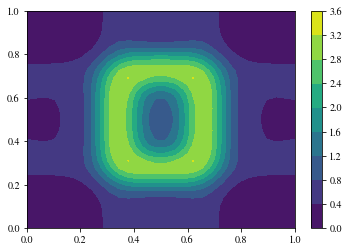

In [11]:
# test if using enough fourier bases for a reasonable reconstruction
phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(xvec, k), mi_dist.flatten())
phik = phik/phik[0]
phik = phik/hk
phik_recon = np.dot(phik, vmap(fk_vmap, in_axes=(None, 0))(xvec, k)).reshape((size, size))
plt.contourf(x1g, x2g, phik_recon)
plt.colorbar()
plt.show()

In [12]:
# run this to release video capture if needed
import cv2
cap = cv2.VideoCapture(0)
cap.release()

In [14]:
# capture a video to run this on
nframes = 1500
input('press enter if you want to get rid of previous video and record a new one')
video = sensor.get_video(nframes)

NameError: name 'sensor' is not defined

In [ ]:
input('Press enter if you want to save the video')
for i in range(nframes):
    np.save(f'video10/{i}.npy', video[i])

Press enter if you want to save the video


In [ ]:
input('Press enter to load the video')
video = []
for i in range(nframes):
    video.append(np.load(f'video2/{i}.npy'))

KeyboardInterrupt: Interrupted by user

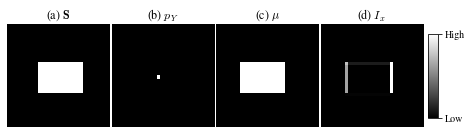

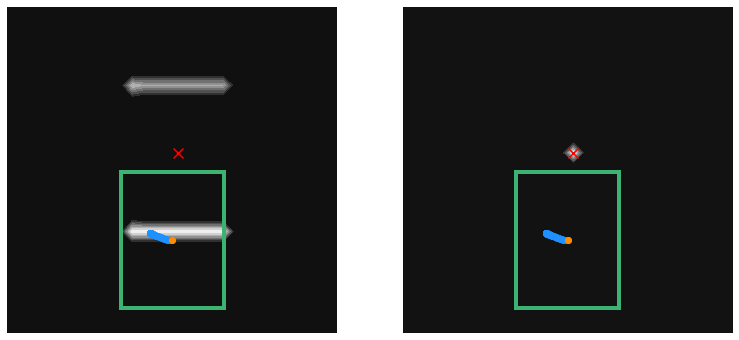

False
rmse: 3.845275205094367e-05 entropy: 1.8404123693471774e-05 0 1499


In [16]:
# run ergodic coverage
nframes = 1500 # EK: added bc it was previously undefined unless ya run previous cells
log = []
history = []

sigma_ekf = .012

from scipy.stats import norm
gaus_sd = .4

mses_cam_alpha = []
entropies_cam_alpha = []

onp.random.seed(0)
# target_is = onp.array([0])
target_is = onp.random.choice(onp.arange(x1.shape[0]), p=p_dist.flatten(), size=30)
for sim in [0]:#range(target_is.shape[0]):
#     video = []
#     for i in range(nframes):
#         video.append(np.load(f'video{sim+1}/{i}.npy'))
        
    target_i = target_is[sim]
    print(target_i)
    dist_cur = p_dist.flatten()
    x0 = np.array([0.2, 0.8])
    u  = np.zeros((50,2))

    opt_init, opt_update, get_params = optimizers.adam(1e-3)
    opt_state = opt_init(u)

    squared_dist = (x1[target_i] - x1)**2 + (x2[target_i] - x2)**2 
    
#     gnd_truth_dist = np.ones(size**2)
#     gnd_truth_dist = gnd_truth_dist / np.sum(gnd_truth_dist)
    
    mses_run = []
    entropies_run = []
    mse = onp.sum(dist_cur * squared_dist)
    mses_run.append(mse)
    entropy = -onp.sum(dist_cur[dist_cur!=0] * onp.log(dist_cur[dist_cur!=0]))
    entropies_run.append(entropy)
    for i in range(nframes):
        # apply gaussian movement noise for the target
#         dist_cur = gaussian_filter(dist_cur.reshape((size, size)), sigma=sigma_ekf*size).flatten()
#         dist_cur = dist_cur / onp.sum(dist_cur)
        
#         gnd_truth_dist = gaussian_filter(gnd_truth_dist.reshape((size, size)), sigma=sigma_ekf*size).flatten()
#         gnd_truth_dist = gnd_truth_dist / onp.sum(gnd_truth_dist)

        mi_dist = mi(dist_cur.reshape((size, size)), rect_dims)
        if np.max(mi_dist) < 1e-9:
            mi_dist_normed = np.ones((size, size)) / size**2
        else:
            mi_dist_normed = mi_dist / np.sum(mi_dist)
        phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(xvec, k), mi_dist_normed.flatten())
        phik = phik/phik[0]
        phik = phik/hk

        history.append(x0.copy())
        for j in range(5):
            g = dl(u, x0, phik, k, np.stack(history[-100:]))
            u = u - 1e-3 * g
    
        x0, _ = f(x0, u[0])
#         px_x1 = int(x0[1] * image_size[0])
#         px_x2 = int(x0[0] * image_size[1])
        
#         bounding_box = [px_x1 - 100, px_x1 + 100, px_x2 - 100, px_x2 + 100]

        inside_fp = (
            (x1 > (x0[0] - rect_dims[0] / 2)) & (x1 < (x0[0] + rect_dims[0] / 2)) &
            (x2 > (x0[1] - rect_dims[1] / 2)) & (x2 < (x0[1] + rect_dims[1] / 2))
        )
        # simulate observations
        if (
            (inside_fp[target_i] and onp.random.random() < T) or
            (not inside_fp[target_i] and onp.random.random() < F)
        ):
            # see the target
#             dist_cur[inside_fp] *= T * norm.pdf(np.sqrt((x1[inside_fp] - x0[0])**2 + (x2[inside_fp] - x0[1])**2), scale=gaus_sd)
            dist_cur[inside_fp] *= T
            dist_cur[~inside_fp] *= F
        else:
            dist_cur[inside_fp] *= (1 - T)
            dist_cur[~inside_fp] *= (1 - F)

#         true_image_index = onp.unravel_index(onp.argmax(sensor._red_ratio(video[i])), video[i].shape[0:2])
#         true_loc = true_image_index / onp.array([480, 640])
#         dists = onp.sqrt(onp.square(x1 - true_loc[0]) + onp.square(x2 - true_loc[1]))
#         gnd_truth_dist = (gnd_truth_dist * .1) + (gnd_truth_dist * .9 * norm.pdf(dists, scale=.05))
#         x1_est = x2[onp.argmax(gnd_truth_dist)]
#         x2_est = x1[onp.argmax(gnd_truth_dist)]
#         squared_dist = onp.square(x1_est - x1) + onp.square(x2_est - x2)
            
#         # get observations from the classifier
#         if sensor.get_predictions(i, video, [bounding_box])[0]:
#             # see the target
#             dist_cur[inside_fp] *= T #* norm.pdf(np.sqrt((x1[inside_fp] - x0[0])**2 + (x2[inside_fp] - x0[1])**2), scale=gaus_sd)
#             dist_cur[~inside_fp] *= F
#         else:
#             # don't see the target
#             dist_cur[inside_fp] *= (1 - T)
#             dist_cur[~inside_fp] *= (1 - F)

        dist_cur = dist_cur / onp.sum(dist_cur)

        mse = onp.sum(dist_cur * squared_dist)
        mses_run.append(mse)
        entropy = -onp.sum(dist_cur[dist_cur!=0] * onp.log(dist_cur[dist_cur!=0]))
        entropies_run.append(entropy)
        
        u = index_update(u, index[:-1,:], u[1:,:])
        u = index_update(u, index[-1,:], 0.)
        if i % 1 == 0:
            log.append(fourier_ergodic_loss(u, x0, phik, k, np.stack(history[-10:])).copy())
            xf, tr = scan(f, x0, u)

#             fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6))
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
            im1 = ax1.contourf(x1g, x2g, mi_dist.reshape((size, size)), cmap='gray')#, extent=(0,1,0,1))
#             fig.colorbar(im1, ax=ax1)
#             ax1.add_patch(
#                 Rectangle(
#                     [x0[0] - rect_dims[0]/2, x0[1] - rect_dims[1]/2], 
#                     rect_dims[0], rect_dims[1], 
#                     color='mediumseagreen', fill=False, lw=4
#                 )
#             )
            ax1.add_patch(
                Rectangle(
                    [x0[0] - rect_dims[0]/2, x0[1] - rect_dims[1]/2], 
                    rect_dims[0], rect_dims[1], 
                    color='mediumseagreen', fill=False, lw=4
                )
            )
            
            ax1.scatter(tr[:,0],tr[:,1], c='dodgerblue')
            ax1.scatter(x0[0], x0[1], c='darkorange')
#             ax1.scatter(x1_est, x2_est, c='red', marker='x', s=100)
            ax1.scatter(x1[target_i], x2[target_i], c='red', marker='x', s=100)
            im2 = ax2.contourf(x1g, x2g, dist_cur.reshape((size, size)), cmap='gray')
#             fig.colorbar(im2, ax=ax2)
            
#             ax2.scatter(x1[target_i], x2[target_i], c='red', marker='x')
            
#             sensor.show(i, video, [bounding_box], ax3)
#             ax2.imshow(video[i], extent=(0, 1, 1, 0))
#             high_prob = dist_cur > (.1 * onp.max(dist_cur))
#             ax2.contour(
#                 x1g, x2g, dist_cur.reshape((size, size)), 
#                 levels=5, colors='red', linewidths=3, alpha=.3
#             )
            ax2.add_patch(
                Rectangle(
                    [x0[0] - rect_dims[0]/2, x0[1] - rect_dims[1]/2], 
                    rect_dims[0], rect_dims[1], 
                    color='mediumseagreen', fill=False, lw=4
                )
            )
            ax2.scatter(tr[:,0],tr[:,1], c='dodgerblue')
            ax2.scatter(x0[0], x0[1], c='darkorange')
#             ax2.scatter(x1_est, x2_est, c='red', marker='x', s=100)
            ax2.scatter(x1[target_i], x2[target_i], c='red', marker='x', s=100)

            ax1.set_xlim(0, 1)
            ax1.set_ylim(1, 0)
            ax2.set_xlim(0, 1)
            ax2.set_ylim(1, 0)
            ax1.axis('off')
#             ax1.axis('equal')
            ax2.axis('off')
#             ax2.axis('equal')
#             ax2.axis('equal')
#             ax3.axis('off')
#             ax3.axis('equal')
#             ax2.axis('equal')
    #         plt.ylim(0,1)
    #         plt.xlim(0,1)
#             ax1.axis('equal')
#             ax2.axis('equal')
    #         ax3.axis('equal')

            fig.savefig(f'frames_demo/{i:04d}.pdf')
            plt.pause(.001)
            plt.show()
            
            print(inside_fp[target_i])
            print(f'rmse: {np.sqrt(mse)} entropy: {entropy}', sim, i)
            clear_output(wait=True)
    mses_cam_alpha.append(mses_run)
    entropies_cam_alpha.append(entropies_run) 

In [ ]:
input('press enter if you want to override the old data')
np.save('mses_cam_mi.npy', np.array(mses_cam_mi))
np.save('entropies_cam_mi.npy', np.array(entropies_cam_mi))

press enter if you want to override the old data


In [ ]:
input('press enter if you want to override the old data')
np.save('mses_cam_p.npy', np.array(mses_cam_p))
np.save('entropies_cam_p.npy', np.array(entropies_cam_p))

press enter if you want to override the old data


In [ ]:
input('press enter if you want to override the old data')
np.save('mses_cam_bias.npy', np.array(mses_cam_bias))
np.save('entropies_cam_bias.npy', np.array(entropies_cam_bias))

press enter if you want to override the old data


In [ ]:
input('press enter if you want to override the old data')
np.save('mses_cam_alpha.npy', np.array(mses_cam_alpha))
np.save('entropies_cam_alpha.npy', np.array(entropies_cam_alpha))

press enter if you want to override the old data


In [ ]:
input('press enter if you want to override the old data')
np.save('mses_alpha.npy', np.array(mses_alpha))
np.save('entropies_alpha.npy', np.array(entropies_alpha))

press enter if you want to override the old data


In [ ]:
input('press enter if you want to override the old data')
np.save('mses_biased.npy', np.array(mses_biased))
np.save('entropies_biased.npy', np.array(entropies_biased))

press enter if you want to override the old data


In [ ]:
input('press enter if you want to override the old data')
np.save('mses_mi.npy', np.array(mses_mi))
np.save('entropies_mi.npy', np.array(entropies_mi))

press enter if you want to override the old data


In [ ]:
input('press enter if you want to override the old data')
np.save('mses_p.npy', np.array(mses_p))
np.save('entropies_p.npy', np.array(entropies_p))

press enter if you want to override the old data


In [18]:
input('press enter if you want to load the data')
mses_mi = np.load('mses_mi.npy')
entropies_mi = np.load('entropies_mi.npy')

In [19]:
input('press enter if you want to load the data')
mses_alpha = np.load('mses_alpha.npy')
entropies_alpha = np.load('entropies_alpha.npy')

In [20]:
input('press enter if you want to load the data')
mses_biased = np.load('mses_biased.npy')
entropies_biased = np.load('entropies_biased.npy')

In [21]:
input('press enter if you want to load the data')
mses_p = np.load('mses_p.npy')
entropies_p = np.load('entropies_p.npy')

In [22]:
input('press enter if you want to load the data')
mses_cam_p = np.load('mses_cam_p.npy')
entropies_cam_p = np.load('entropies_cam_p.npy')
mses_cam_mi = np.load('mses_cam_mi.npy')
entropies_cam_mi = np.load('entropies_cam_mi.npy')
mses_cam_alpha = np.load('mses_cam_alpha.npy')
entropies_cam_alpha = np.load('entropies_cam_alpha.npy')
mses_cam_bias = np.load('mses_cam_bias.npy')
entropies_cam_bias = np.load('entropies_cam_bias.npy')

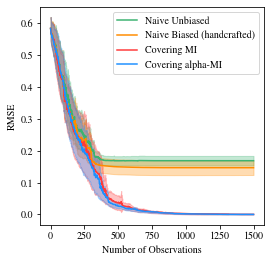

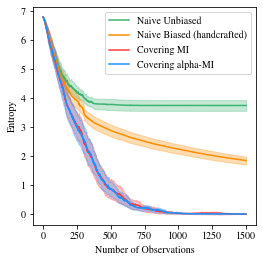

In [23]:
# simulation plots
from scipy.stats import sem
ts = np.arange(mses_p.shape[1])

colors = ['#3CB371', '#FF8C00', '#FF3A3A', '#1E90FF']

mean_mse_p = onp.mean(np.sqrt(mses_p), axis=0)
sem_mse_p = sem(np.sqrt(mses_p), axis=0)
mean_mse_bias = onp.mean(np.sqrt(mses_biased), axis=0)
sem_mse_bias = sem(np.sqrt(mses_biased), axis=0)
mean_mse_mi = onp.mean(np.sqrt(mses_mi), axis=0)
sem_mse_mi = sem(np.sqrt(mses_mi), axis=0)
mean_mse_alpha = onp.mean(np.sqrt(mses_alpha), axis=0)
sem_mse_alpha = sem(np.sqrt(mses_alpha), axis=0)
# mean_mse_uni = onp.mean(mses_uni, axis=0)
# sem_mse_uni = sem(mses_uni, axis=0)

plt.figure(figsize=(4, 4))
plt.fill_between(ts, mean_mse_p - 2*sem_mse_p, mean_mse_p + 2*sem_mse_p, alpha=.3, color=colors[0])
plt.fill_between(ts, mean_mse_bias - 2*sem_mse_bias, mean_mse_bias + 2*sem_mse_bias, alpha=.3, color=colors[1])
plt.fill_between(ts, mean_mse_mi - 2*sem_mse_mi, mean_mse_mi + 2*sem_mse_mi, alpha=.3, color=colors[2])
plt.fill_between(ts, mean_mse_alpha - 2*sem_mse_alpha, mean_mse_alpha + 2*sem_mse_alpha, alpha=.3, color=colors[3])
# plt.fill_between(ts, mean_mse_uni - 2*sem_mse_uni, mean_mse_uni + 2*sem_mse_uni, alpha=.5)
plt.plot(ts, mean_mse_p, label='Naive Unbiased', color=colors[0])
plt.plot(ts, mean_mse_bias, label='Naive Biased (handcrafted)', color=colors[1])
plt.plot(ts, mean_mse_mi, label='Covering MI', color=colors[2])
plt.plot(ts, mean_mse_alpha, label='Covering alpha-MI', color=colors[3])
# plt.plot(ts, mean_mse_uni, label='Uniform')
plt.legend()
plt.xlabel('Number of Observations')
plt.ylabel('RMSE')
# plt.title('MSE vs. Time')
plt.savefig('rmse.pdf')
plt.show()

mean_ent_p = onp.mean(entropies_p, axis=0)
sem_ent_p = sem(entropies_p, axis=0)
mean_ent_bias = onp.mean(entropies_biased, axis=0)
sem_ent_bias = sem(entropies_biased, axis=0)
mean_ent_mi = onp.mean(entropies_mi, axis=0)
sem_ent_mi = sem(entropies_mi, axis=0)
mean_ent_alpha = onp.mean(entropies_alpha, axis=0)
sem_ent_alpha = sem(entropies_alpha, axis=0)

plt.figure(figsize=(4, 4))
plt.fill_between(ts, mean_ent_p - 2*sem_ent_p, mean_ent_p + 2*sem_ent_p, alpha=.3, color=colors[0])
plt.fill_between(ts, mean_ent_bias - 2*sem_ent_bias, mean_ent_bias + 2*sem_ent_bias, alpha=.3, color=colors[1])
plt.fill_between(ts, mean_ent_mi - 2*sem_ent_mi, mean_ent_mi + 2*sem_ent_mi, alpha=.3, color=colors[2])
plt.fill_between(ts, mean_ent_alpha - 2*sem_ent_alpha, mean_ent_alpha + 2*sem_ent_alpha, alpha=.3, color=colors[3])
# plt.fill_between(ts, mean_ent_uni - 2*sem_ent_uni, mean_ent_uni + 2*sem_ent_uni, alpha=.5)
plt.plot(ts, mean_ent_p, label='Naive Unbiased', color=colors[0])
plt.plot(ts, mean_ent_bias, label='Naive Biased (handcrafted)', color=colors[1])
plt.plot(ts, mean_ent_mi, label='Covering MI', color=colors[2])
plt.plot(ts, mean_ent_alpha, label='Covering alpha-MI', color=colors[3])
# plt.plot(ts, mean_ent_uni, label='Uniform')
plt.legend()
plt.xlabel('Number of Observations')
plt.ylabel('Entropy')
plt.savefig('entropy.pdf')
# plt.title('Entropy vs. Time')
plt.show()

/home/enko/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


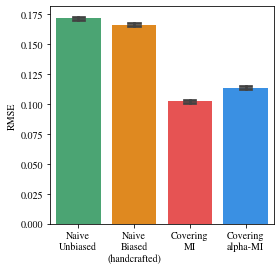

/home/enko/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


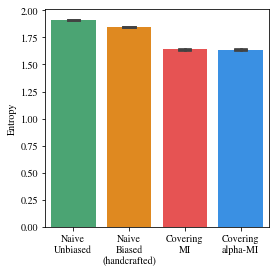

In [24]:
# camera plots
from scipy.stats import sem
import seaborn as sns
ts = onp.arange(mses_cam_p.shape[1])

palette = sns.color_palette(colors)

# bandwidth = 200
# nt = int(np.ceil(-np.log(.01) * bandwidth))
# dt = np.arange(-nt, nt+1)
# weights = np.exp(-np.abs(dt) / bandwidth)
# weights = weights / np.sum(weights)
# cumweight = onp.cumsum(weights)
    
# def smooth(original):
#     smoothed = correlate(original, weights[None, :], mode='same')
#     smoothed[:, 0:nt] = smoothed[:, 0:nt] / cumweight[None, nt:2*nt]
#     smoothed[:, -nt:] = smoothed[:, -nt:] / onp.flip(cumweight[None, nt:2*nt])
#     return smoothed

# for i in range(mses_cam_p.shape[0]):
#     plt.plot(ts, np.sqrt(mses_cam_p[i, :]), c='r')

# smooth_mses_cam_p = smooth(mses_cam_p)
# for i in range(mses_cam_p.shape[0]):
#     plt.plot(ts, np.sqrt(smooth_mses_cam_p[i, :]), c='b')
# plt.show()

# def smooth(original):
#     smoothed = correlate(original, weights, mode='same')
#     smoothed[0:nt] = smoothed[0:nt] / cumweight[nt:2*nt]
#     smoothed[-nt:] = smoothed[-nt:] / onp.flip(cumweight[nt:2*nt])
#     return smoothed

# mean_mse_p = onp.mean(smooth(np.sqrt(mses_cam_p)), axis=0)
# sem_mse_p = sem(smooth(np.sqrt(mses_cam_p)), axis=0)
# mean_mse_bias = onp.mean(smooth(np.sqrt(mses_cam_bias)), axis=0)
# sem_mse_bias = sem(smooth(np.sqrt(mses_cam_bias)), axis=0)
# mean_mse_mi = onp.mean(smooth(np.sqrt(mses_cam_mi)), axis=0)
# sem_mse_mi = sem(smooth(np.sqrt(mses_cam_mi)), axis=0)
# mean_mse_alpha = onp.mean(smooth(np.sqrt(mses_cam_alpha)), axis=0)
# sem_mse_alpha = sem(smooth(np.sqrt(mses_cam_alpha)), axis=0)
# # mean_mse_uni = onp.mean(mses_uni, axis=0)
# # sem_mse_uni = sem(mses_uni, axis=0)

# plt.figure(figsize=(5, 5))
# plt.fill_between(ts, mean_mse_p - 2*sem_mse_p, mean_mse_p + 2*sem_mse_p, alpha=.2, color=colors[0])
# plt.fill_between(ts, mean_mse_bias - 2*sem_mse_bias, mean_mse_bias + 2*sem_mse_bias, alpha=.2, color=colors[1])
# plt.fill_between(ts, mean_mse_mi - 2*sem_mse_mi, mean_mse_mi + 2*sem_mse_mi, alpha=.2, color=colors[2])
# plt.fill_between(ts, mean_mse_alpha - 2*sem_mse_alpha, mean_mse_alpha + 2*sem_mse_alpha, alpha=.2, color=colors[3])
# # plt.fill_between(ts, mean_mse_uni - 2*sem_mse_uni, mean_mse_uni + 2*sem_mse_uni, alpha=.5)
# plt.plot(ts, mean_mse_p, label='Naive Unbiased', color=colors[0])
# plt.plot(ts, mean_mse_bias, label='Naive Biased (handcrafted)', color=colors[1])
# plt.plot(ts, mean_mse_mi, label='Covering MI', color=colors[2])
# plt.plot(ts, mean_mse_alpha, label='Covering alpha-MI', color=colors[3])
# # plt.plot(ts, mean_mse_uni, label='Uniform')
# plt.legend()
# plt.xlabel('Number of Observations')
# plt.ylabel('RMSE')
# # plt.title('MSE vs. Time')
# plt.savefig('rmse_cam.pdf')
# plt.show()

# ts = 200
# plt.figure(figsize=(10, 10))
# n = mses_cam_p[:, 0:ts].flatten().shape[0]
# labels = ['Naive Unbiased']*n + ['Naive Biased (handcrafted)']*n + ['Covering MI']*n + ['Covering alpha-MI']*n
# values = np.concatenate([
#     np.sqrt(mses_cam_p[:, 0:ts]).flatten(),
#     np.sqrt(mses_cam_bias[:, 0:ts]).flatten(),
#     np.sqrt(mses_cam_mi[:, 0:ts]).flatten(),
#     np.sqrt(mses_cam_alpha[:, 0:ts]).flatten()
# ])
# sns.barplot(labels, values, capsize=.2, ci=95, palette=palette)
# plt.ylabel('RMSE (before time 200)')
# plt.show()

ts = 300
plt.figure(figsize=(4, 4))
n = mses_cam_p[:, ts:].flatten().shape[0]
labels = (
    ['Naive\nUnbiased']*n + ['Naive\nBiased\n(handcrafted)']*n + 
    ['Covering\nMI']*n + ['Covering\nalpha-MI']*n
)
values = np.concatenate([
    np.sqrt(mses_cam_p[:, ts:]).flatten(),
    np.sqrt(mses_cam_bias[:, ts:]).flatten(),
    np.sqrt(mses_cam_mi[:, ts:]).flatten(),
    np.sqrt(mses_cam_alpha[:, ts:]).flatten()
])
sns.barplot(labels, values, capsize=.2, ci=95, palette=palette)
plt.ylabel('RMSE')
plt.savefig('rmse_after200.pdf')
plt.show()

# mean_ent_p = onp.mean(smooth(entropies_cam_p), axis=0)
# sem_ent_p = sem(smooth(entropies_cam_p), axis=0)
# mean_ent_bias = onp.mean(smooth(entropies_cam_bias), axis=0)
# sem_ent_bias = sem(smooth(entropies_cam_bias), axis=0)
# mean_ent_mi = onp.mean(smooth(entropies_cam_mi), axis=0)
# sem_ent_mi = sem(smooth(entropies_cam_mi), axis=0)
# mean_ent_alpha = onp.mean(smooth(entropies_cam_alpha), axis=0)
# sem_ent_alpha = sem(smooth(entropies_cam_alpha), axis=0)

# plt.figure(figsize=(5, 5))
# plt.fill_between(ts, mean_ent_p - 2*sem_ent_p, mean_ent_p + 2*sem_ent_p, alpha=.2, color=colors[0])
# plt.fill_between(ts, mean_ent_bias - 2*sem_ent_bias, mean_ent_bias + 2*sem_ent_bias, alpha=.2, color=colors[1])
# plt.fill_between(ts, mean_ent_mi - 2*sem_ent_mi, mean_ent_mi + 2*sem_ent_mi, alpha=.2, color=colors[2])
# plt.fill_between(ts, mean_ent_alpha - 2*sem_ent_alpha, mean_ent_alpha + 2*sem_ent_alpha, alpha=.2, color=colors[3])
# # plt.fill_between(ts, mean_ent_uni - 2*sem_ent_uni, mean_ent_uni + 2*sem_ent_uni, alpha=.5)
# plt.plot(ts, mean_ent_p, label='Naive Unbiased', color=colors[0])
# plt.plot(ts, mean_ent_bias, label='Naive Biased (handcrafted)', color=colors[1])
# plt.plot(ts, mean_ent_mi, label='Covering MI', color=colors[2])
# plt.plot(ts, mean_ent_alpha, label='Covering alpha-MI', color=colors[3])
# # plt.plot(ts, mean_ent_uni, label='Uniform')
# plt.legend()
# plt.xlabel('Number of Observations')
# plt.ylabel('Entropy')
# # plt.title('Entropy vs. Time')
# plt.savefig('entropy_cam.pdf')
# plt.show()

plt.figure(figsize=(4, 4))
values = np.concatenate([
    np.sqrt(entropies_cam_p[:, ts:]).flatten(),
    np.sqrt(entropies_cam_bias[:, ts:]).flatten(),
    np.sqrt(entropies_cam_mi[:, ts:]).flatten(),
    np.sqrt(entropies_cam_alpha[:, ts:]).flatten()
])
sns.barplot(labels, values, capsize=.2, ci=95, palette=palette)
# plt.legend()
# plt.xticks(rotation=10, ha='right')
plt.ylabel('Entropy')
plt.savefig('entropy_after200.pdf')
plt.show()

In [ ]:
print(np.mean((np.sqrt(mses_cam_p[:, ts:]) - np.sqrt(mses_cam_p[:, ts:]))) / np.mean(np.sqrt(mses_cam_p[:, ts:])))
print(np.mean((np.sqrt(mses_cam_p[:, ts:]) - np.sqrt(mses_cam_bias[:, ts:]))) / np.mean(np.sqrt(mses_cam_p[:, ts:])))
print(np.mean((np.sqrt(mses_cam_p[:, ts:]) - np.sqrt(mses_cam_mi[:, ts:]))) / np.mean(np.sqrt(mses_cam_p[:, ts:])))
print(np.mean((np.sqrt(mses_cam_p[:, ts:]) - np.sqrt(mses_cam_alpha[:, ts:]))) / np.mean(np.sqrt(mses_cam_p[:, ts:])))

0.0
0.03135912
0.40455848
0.33716166


In [25]:
mean = np.mean(np.sqrt(mses_cam_alpha))
se = sem(np.sqrt(mses_cam_alpha).flatten())
print(mean, mean+2*se, mean-2*se)

0.12856422 0.13027802 0.12685043


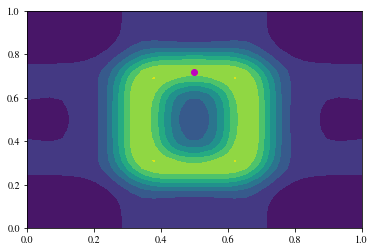

In [42]:
log = []
history = np.array([x0])
for i in range(1500):
    g = dl(get_params(opt_state), x0, phik, k, history) # EK: fourier_ergodic_loss needs history parameter
    opt_state = opt_update(i, g, opt_state)
    
    if (i) % 100 == 0:
        u = get_params(opt_state)
        log.append(fourier_ergodic_loss(u, x0, phik, k, history).copy()) # EK: fourier_ergodic_loss needs history parameter
        clear_output(wait=True)
        xf, tr = scan(f, x0, u) #########3not sure how to resolve
        # history = cat([tr, history])
        
        clear_output(wait=True)
        plt.contourf(x1g, x2g, phik_recon)
        plt.scatter(tr[:,0],tr[:,1], c='m')
#         plt.ylim(0,1)
#         plt.xlim(0,1)
        plt.pause(0.001)
        i+=1
        plt.show()

In [ ]:
for t in range(tr.shape[0]):
    fig, ax = plt.subplots()
    ax.contourf(x1g, x2g, phik_recon)
    ax.plot(tr[:t+1,0],tr[:t+1,1], c='m')
    footprint = Circle(tr[t,:2], r, fill=False)
    ax.add_patch(footprint)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    fig.savefig(f'frames/{t:04d}.jpg')
    plt.show()

In [ ]:
# ck reconstruction
ck = get_ck(tr, k)
ck_recon = np.dot(ck, vmap(fk_vmap, in_axes=(None, 0))(xy, k)).reshape((size, size))
plt.contourf(x1g, x2g, ck_recon)
plt.scatter(tr[:,0],tr[:,1], c='m', alpha=.5)
plt.colorbar()

In [ ]:
def simulate_errors(distribution, x1, x2, traj, r, T, nsim=500):
    entropies = onp.zeros((nsim, traj.shape[0]))
    mses = onp.zeros((nsim, traj.shape[0]))
    for i in range(nsim):
        print(i)
        dist_cur = distribution.flatten()
        target_i = onp.random.choice(onp.arange(x1.shape[0]), p=distribution.flatten())
        for t in range(traj.shape[0]):
            inside_fp = ((traj[t, 0] - x1)**2 + (traj[t, 1] - x2)**2) < r**2
            if inside_fp[target_i] and (onp.random.random() < T):
                # see the target
                dist_cur[~inside_fp] = 0
            else:
                # don't see the target
                dist_cur[inside_fp] = dist_cur[inside_fp] * (1 - T)
            dist_cur = dist_cur / onp.sum(dist_cur)
            mses[i, t] = onp.sum(((x1 - x1[target_i])**2 + (x2 - x2[target_i])**2) * dist_cur)
            entropies[i, t] = -onp.sum(dist_cur[dist_cur>1e-9] * onp.log(dist_cur[dist_cur>1e-9]))
    return mses, entropies

In [ ]:
mses_uni, entropies_uni = simulate_errors(p_dist, x1, x2, tr, r, T)

In [ ]:
from scipy.stats import sem
ts = np.arange(tr.shape[0]) + 1

mean_mse = onp.mean(mses, axis=0)
sem_mse = sem(mses, axis=0)
mean_mse_mi = onp.mean(mses_mi, axis=0)
sem_mse_mi = sem(mses_mi, axis=0)
mean_mse_uni = onp.mean(mses_uni, axis=0)
sem_mse_uni = sem(mses_uni, axis=0)

plt.fill_between(ts, mean_mse - 2*sem_mse, mean_mse + 2*sem_mse, alpha=.5)
plt.fill_between(ts, mean_mse_mi - 2*sem_mse_mi, mean_mse_mi + 2*sem_mse_mi, alpha=.5)
plt.fill_between(ts, mean_mse_uni - 2*sem_mse_uni, mean_mse_uni + 2*sem_mse_uni, alpha=.5)
plt.plot(ts, mean_mse, label='p(x)')
plt.plot(ts, mean_mse_mi, label='I(x)')
plt.plot(ts, mean_mse_uni, label='Uniform')
plt.legend()
plt.title('MSE vs. Time')
plt.show()

mean_ent = onp.mean(entropies, axis=0)
sem_ent = sem(entropies, axis=0)
mean_ent_mi = onp.mean(entropies_mi, axis=0)
sem_ent_mi = sem(entropies_mi, axis=0)
mean_ent_uni = onp.mean(entropies_uni, axis=0)
sem_ent_uni = sem(entropies_uni, axis=0)

plt.fill_between(ts, mean_ent - 2*sem_ent, mean_ent + 2*sem_ent, alpha=.5)
plt.fill_between(ts, mean_ent_mi - 2*sem_ent_mi, mean_ent_mi + 2*sem_ent_mi, alpha=.5)
plt.fill_between(ts, mean_ent_uni - 2*sem_ent_uni, mean_ent_uni + 2*sem_ent_uni, alpha=.5)
plt.plot(ts, mean_ent, label='p(x)')
plt.plot(ts, mean_ent_mi, label='I(x)')
plt.plot(ts, mean_ent_uni, label='Uniform')
plt.legend()
plt.title('Entropy vs. Time')
plt.show()